In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from pandas.io.json import json_normalize #package for flattening json in pandas df
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import category_encoders as ce
import glob
import re
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import base
from sklearn.model_selection import KFold
import os
from sklearn.preprocessing import StandardScaler

%matplotlib inline



Using TensorFlow backend.


In [2]:
df_pet = pd.read_csv("../input/train/train.csv")
df_pet.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [3]:
df_pet.shape

(14993, 24)

In [4]:
df_pet.dtypes

Type               int64
Name              object
Age                int64
Breed1             int64
Breed2             int64
Gender             int64
Color1             int64
Color2             int64
Color3             int64
MaturitySize       int64
FurLength          int64
Vaccinated         int64
Dewormed           int64
Sterilized         int64
Health             int64
Quantity           int64
Fee                int64
State              int64
RescuerID         object
VideoAmt           int64
Description       object
PetID             object
PhotoAmt         float64
AdoptionSpeed      int64
dtype: object

<H1>Exploratory Data Analysis</H1>

In [5]:
df_pet.describe()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,1.457614,10.452078,265.272594,74.009738,1.776162,2.234176,3.222837,1.882012,1.862002,1.467485,1.731208,1.558727,1.914227,1.036617,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,0.498217,18.155790,60.056818,123.011575,0.681592,1.745225,2.742562,2.984086,0.547959,0.599070,0.667649,0.695817,0.566172,0.199535,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,2.000000,12.000000,307.000000,179.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,2.000000,255.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


<H2>Imbalance Dataset</H2>
First of all, the dataset is imbalaced.  There is only 2.7% of AdoptionSpeed = 0 (adopted on the same day it was listed).

In [6]:
df_pet.groupby('AdoptionSpeed')['AdoptionSpeed'].count()

AdoptionSpeed
0     410
1    3090
2    4037
3    3259
4    4197
Name: AdoptionSpeed, dtype: int64

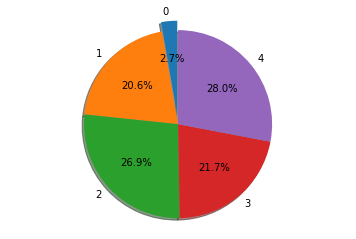

In [7]:
labels = '0', '1', '2', '3', '4'
sizes = df_pet.groupby('AdoptionSpeed')['AdoptionSpeed'].count()
explode = (0.1, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<H3>Breed</H3>

<H2>Incorrect/Insufficient Data</H2>
When we do a query on the breed of the pets (as shown below), we noticed that there are 5927 pets with BreedId 307 (Mixed Breed) and 5 with BreedId 0 (Not available).<br>
Firstly, there are no Breed 0 in the breed lookup table.  That means the breed of the pet is not available.  <br>
Secondly, breed 307 means Mixed Breed in the lookup table.  That means the owner might not know the correct breed of the pets except that they know it is a mixed breed.  <br>
For pets with these 2 kind of breeds, we might be able to gather more information about the correct breeds from the images of the pets.  These could be obtained from the metadata of the images which has been preprossed using Google Vision API<br>  

In [8]:
df_pet[(df_pet['Breed1'] == 0) | (df_pet['Breed1'] == 307)].groupby('Breed1')['Breed1'].count()

Breed1
0         5
307    5927
Name: Breed1, dtype: int64

Next, we do not want to include feature that have less than or equal to 5 records.  This is because the data is either incorrect or it is too specific which will affect how the machine learning algorithm learns.  These records will be removed in the 'Cleaning Data' section.  However, these numbers might change after we gather the correct breed from the pet images.

In [9]:
df_pet.groupby(['Breed1', 'Breed2']).filter(lambda x: len(x) <= 5)['Breed1'].count()

1059

The bar chart below shows the top 10 breed for dogs based on each adoption speed.

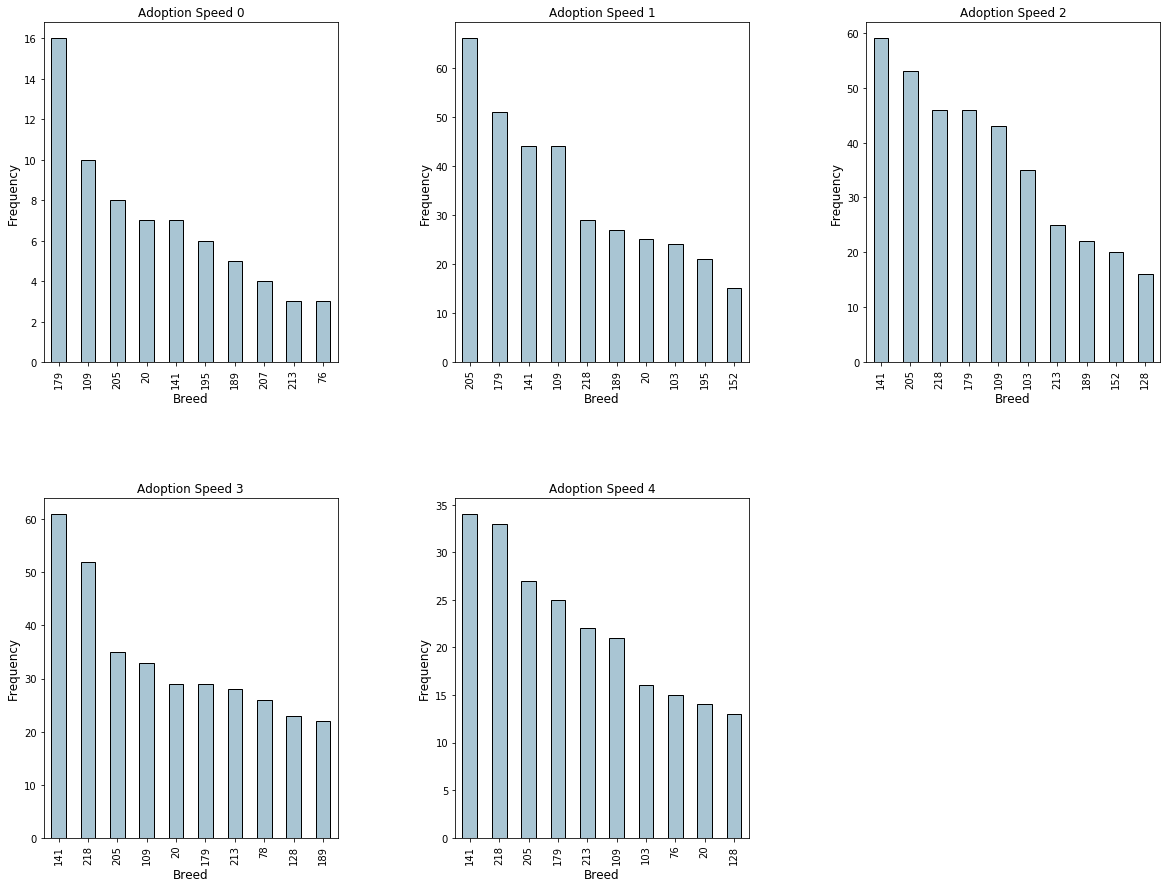

In [10]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_figheight(15)
fig.set_figwidth(20)
for i in range(1, 6):
    ax = fig.add_subplot(2, 3, i)
    ax = df_pet[(df_pet['AdoptionSpeed'] == i-1) & (df_pet['Type'] == 1) & (df_pet['Breed1'] != 307)].groupby('Breed1')['PetID'].count().sort_values(ascending=False).head(10).plot.bar(color='#A9C5D3', edgecolor='black',  
                          grid=False)
    ax.set_title('Adoption Speed {}'.format(i-1))
    ax.set_xlabel('Breed', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)


<H3>Age</H3>

Text(0, 0.5, 'Frequency')

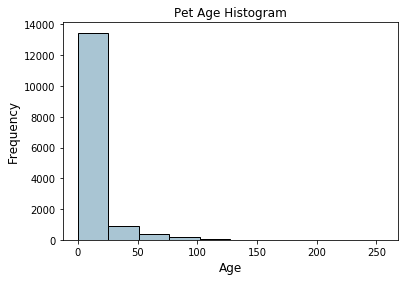

In [11]:
fig, ax = plt.subplots()
df_pet['Age'].hist(color='#A9C5D3', edgecolor='black',  
                          grid=False)
ax.set_title('Pet Age Histogram', fontsize=12)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

From the histogram above, we can see that the age distribution is not very good.  Therefore, we might want to remove age that has less or equal to 5 records.

In [12]:
df_pet.groupby("Age").filter(lambda x: len(x) <= 5)['Age'].count()

106

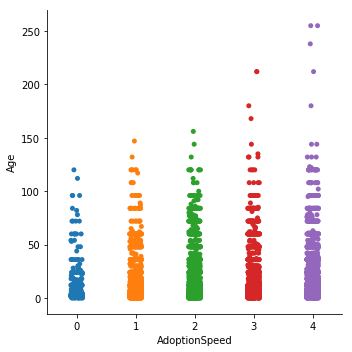

In [13]:
sns.catplot(x="AdoptionSpeed", y="Age", data=df_pet)

<H3>Color</H3>

Same goes color feature where any color combination that has less or equal to 5 records will be removed.

In [14]:
df_pet.groupby(['Color1', 'Color2', 'Color3']).filter(lambda x: len(x) <= 5)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
1787,2,Novi,1,266,0,1,3,4,6,2,2,2,2,2,1,1,0,41326,3f50f2f416e698600bc9d3c1accf5a9e,0,abandoned kitten found in neighbourhood cute w...,fe5bc83d2,3.0,3
4531,2,3 Little Kitten,1,266,0,3,3,4,6,1,1,1,1,2,1,3,0,41326,29d21c8d73c1c4f10395242553a61a7c,0,These 3 kittens were born at my house. Their m...,3338e5ec6,5.0,3
6925,2,Young Kittens,1,266,0,3,3,4,6,2,1,2,2,2,1,4,0,41401,6ac4171715e5fc1d69131b86a9bec346,0,4 young kittens for adoption. Mix gender. I'm ...,a6278a50c,7.0,2
7124,2,NaN,36,285,0,1,3,4,6,2,2,3,3,3,1,1,0,41401,22d9e67d412f25866e09f2c098a6ebef,0,"Hi guys , i found some abandon dogs and cats i...",1cd5acd7a,4.0,1
7953,2,Looking For A Kitten,4,251,292,1,3,4,6,2,2,1,1,2,1,1,0,41326,63900573e92222eef82b39d0ce28ce17,0,"Hi, I am looking for a Little kitten to adopt ...",10400a0b8,0.0,2


<H3>Maturity Size</H3>
Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)<br>
When maturity size is 0 (Not Specified), meaning this does not give any information to our analysis, which should be removed.<br>
However, nothing need to be done here as there are no Maturity Size 0 in the dataset.

In [15]:
df_pet[df_pet['MaturitySize'] == 0]['MaturitySize'].count()

0

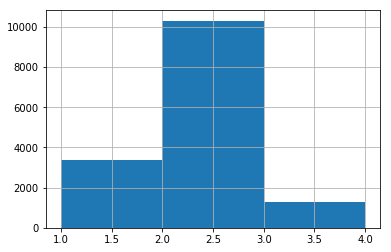

In [16]:
df_pet['MaturitySize'].hist(bins=3)

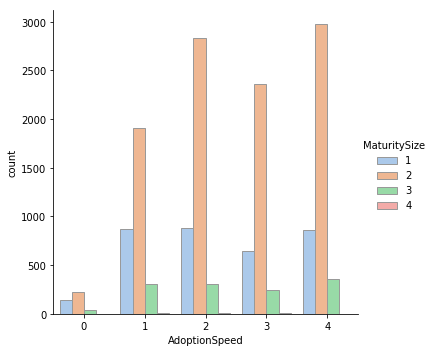

In [17]:
sns.catplot(x="AdoptionSpeed", hue="MaturitySize", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_pet)

From the chart above, we could see that most of the pets have maturity size 2 (Medium)

<H3>Fur Length</H3>
Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)<br>
When fur length is 0 (Not Specified), meaning this does not give any information to our analysis, which should be removed.<br>
However, nothing need to be done here as there are no Fur Length 0 in the dataset.

In [18]:
df_pet[df_pet['FurLength'] == 0]['FurLength'].count()

0

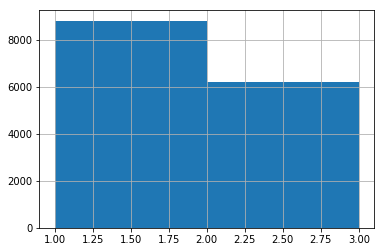

In [19]:
df_pet['FurLength'].hist(bins=2)

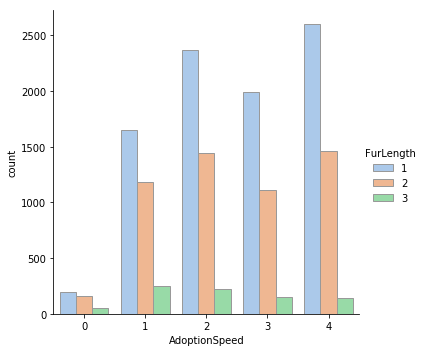

In [20]:
sns.catplot(x="AdoptionSpeed", hue="FurLength", kind="count",
            palette="pastel", edgecolor=".6",
            data=df_pet)

<H3>Health</H3>
Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)<br>
When Health is 0 (Not Specified), meaning this does not give any information to our analysis, which should be removed.<br>
However, nothing need to be done here as there are no Health 0 in the dataset.

In [21]:
df_pet[df_pet['Health'] == 0]['Health'].count()

0

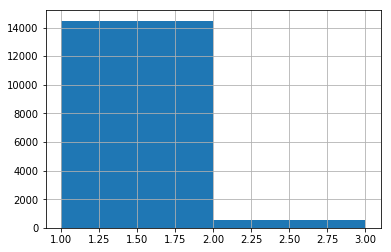

In [22]:
df_pet['Health'].hist(bins=2)

In [23]:
df_pet['Health'].value_counts()

1    14478
2      481
3       34
Name: Health, dtype: int64

<H3>Fee</H3>
Fee should not be selected as a feature.  Out of 14993 samples, 12663 are free of charge.  This means 85% of the samples have fee = 0.  Besides, many other fee values are very specific like one case that have fee $ 3000, one case has fee $ 2000, etc.  Therefore, fee is not a good feature for our model and should be elimited our feature selection.

In [24]:
df_pet[df_pet['Fee'] == 0]['Fee'].count()

12663

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


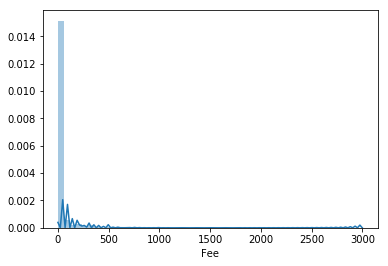

In [25]:
sns.distplot(df_pet['Fee'])

<H3>Photo Amt</H3>

In [26]:
df_pet.groupby("PhotoAmt").filter(lambda x: len(x) <= 5)['PhotoAmt'].count()

0

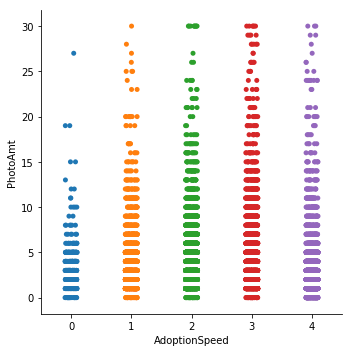

In [27]:
sns.catplot(x="AdoptionSpeed", y="PhotoAmt", data=df_pet)

<H3>Quantity</H3>

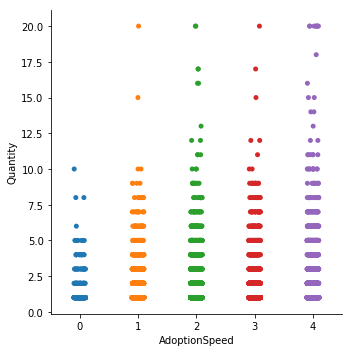

In [28]:
sns.catplot(x="AdoptionSpeed", y="Quantity", data=df_pet)

<H1>Cleaning Data</H1>

In [29]:
def clean_data(df):
    print('cleaning data..')
    # Remove data without primary breed (Breed1 == 0)
    #df_cleaned = df[df['Breed1'] > 0]
    
    # Remove age that has less than or equal to 5 records 
    age_remove_index = df.groupby("Age").filter(lambda x: len(x) <= 5).index.values
    if len(age_remove_index) > 0:
        df.drop(labels=age_remove_index, inplace=True, axis=0)
        df.reset_index(drop=True, inplace=True)
    
    # Remove breed combination which has less than or equal to 5 records
    breed_remove_index = df.groupby(['Breed1', 'Breed2']).filter(lambda x: len(x) <= 5).index.values
    if len(breed_remove_index) > 0:
        df.drop(labels=breed_remove_index, inplace=True, axis=0)
        df.reset_index(drop=True, inplace=True)
        
    print('data cleaned sucessfully!')
    print('final dataset is {}'.format(df.shape))

    return df

<H1>Feature Engineering & Preprocessing</H1>

In [30]:
class OneHotEncoder(base.BaseEstimator,
                               base.TransformerMixin):
    
    def __init__(self,colnames,
                  verbosity=True,
                  discardOriginal_col=True):
        self.colnames = colnames
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        assert(type(self.colnames) == list)
        
        for col in self.colnames:
            onehot_feature = pd.get_dummies(X[col])
            onehotlist = np.sort(X[col].unique())
            onehot_feature.columns = [col + '_' + str(v) for v in onehotlist]
            onehot_feature = onehot_feature.astype(int)
            
            X = pd.concat([X, onehot_feature], axis=1)
            
            if self.discardOriginal_col:
                X.drop(col, axis=1, inplace=True)
        #df.drop(['Gender'], axis=1, inplace=True)
        #X = pd.concat([X, onehot_feature], axis=1)
        return X


In [31]:
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == list)
        assert(any(elem in self.colnames for elem in X.columns)) 
        assert(self.targetName in X.columns)
        
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = False, random_state=2019)
        com_colnames = '_'.join(self.colnames)
        col_mean_name = com_colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X_tr[com_colnames] = X_tr[self.colnames].apply(lambda x: ''.join(map(str,x)),axis=1)
            X_val[com_colnames] = X_val[self.colnames].apply(lambda x: ''.join(map(str,x)),axis=1)
            X.loc[X.index[val_ind], col_mean_name] = X_val[com_colnames].map(X_tr.groupby(com_colnames)[self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
        
        X = X.drop(self.targetName, axis=1)
        X = X.groupby(self.colnames)[col_mean_name].mean().reset_index()
        
        # export as lookup into csv file which is to be used to encode cat feature for eval/test data
        X = X.drop_duplicates()
        filename = com_colnames + '.csv'
        X.to_csv(filename, index=False)
        
        return X

In [32]:
def split_train_test(df, size):

    msk = np.random.rand(len(df)) < size
    train = df[msk]
    test = df[~msk]
    print('split train: {}'.format(train.shape))
    print('split test: {}'.format(test.shape))
    return train, test

def process_sentiments(is_train, df):
    print('processing sentiments..')
    
    files = '../input/train_sentiment/*.json' if is_train else '../input/test_sentiment/*.json'
    
    df_senti = pd.DataFrame()

    for filename in glob.iglob(files, recursive=True):
        with open(filename) as f:
            d = json.load(f)
        
        df_temp = json_normalize(d['documentSentiment'])
        p = re.compile('\-*\.json')
        df_temp['PetID'] = os.path.basename(filename).replace('.json','')
        df_senti = df_senti.append(df_temp)
        
    df_senti.rename(columns={'magnitude':'SentimentMagnitude', 'score':'SentimentScore'}, inplace=True)
    df_senti['SentimentScore'] = df_senti['SentimentScore']**2
    
    df = pd.merge(df, df_senti, how='left', on='PetID')
    df[['SentimentMagnitude', 'SentimentScore']] = df[['SentimentMagnitude', 'SentimentScore']].fillna(0)
    
    return df

def get_breed_from_image(is_train, df):
    print('retrieving breed from images..')
    
    file_type = 'train' if is_train else 'test' 
    
    df_breed = pd.read_csv("../input/breed_labels.csv")
    
    df_empty_breed = df[(df['Breed1'] == 0) | ((df['Breed1'] == 307) & (df['Breed2'] == 0)) | ((df['Breed1'] == 307) & (df['Breed2'] == 307))] 
    
    for index, row in df_empty_breed.iterrows():
        df_metadata = pd.DataFrame()
        pet_id = row['PetID']
        photo_amt = int(row['PhotoAmt'])
        
        for i in range(1, photo_amt+1):
            filename = '../input/{}_metadata/{}-{}.json'.format(file_type, pet_id, str(i))
            if os.path.exists(filename):
                
                with open(filename) as f:
                    d = json.load(f)
        
                p = re.compile('-[0-9]\.json')
                
                if 'labelAnnotations' in d:
                    df_temp = json_normalize(d['labelAnnotations'])
                    #df_temp['PetID'] = p.sub('', os.path.basename(filename))
                    df_temp['PetID'] = pet_id
                    df_metadata = df_metadata.append(df_temp, ignore_index=True)
        
        if not df_metadata.empty:
            sr = df_breed[['BreedID']]
            sr.index = df_breed['BreedName'].str.lower()
            breed_dict = sr.to_dict()
            df_metadata['BreedID'] = df_metadata['description'].str.lower().map(breed_dict['BreedID'])
            df_metadata = df_metadata.dropna(axis=0, how='any')
            
            if not df_metadata.empty:
                df_empty_breed.at[index, 'Breed1'] = df_metadata[df_metadata['PetID'] == pet_id].sort_values(by=['score'], ascending=False).head(1)['BreedID'].values[0]
                df_empty_breed.at[index, 'Breed2'] = 0
    
    df_new = df.merge(df_empty_breed[['PetID', 'Breed1', 'Breed2']], on='PetID', how='left')
    df_new['Breed1'] = np.round(np.where(df_new['Breed1_y'].isnull(), df_new['Breed1_x'], df_new['Breed1_y']), decimals=0)
    df_new['Breed2'] = np.round(np.where(df_new['Breed2_y'].isnull(), df_new['Breed2_x'], df_new['Breed2_y']), decimals=0)
    df_new = df_new.drop(columns=['Breed1_x', 'Breed2_x', 'Breed1_y', 'Breed2_y'])
    
    return df_new

def encode_mul_cat_feature_for_test(x):
    original_cols = x.columns.values
    cols_name = '_'.join(x.columns.values)
    lookup_filename = cols_name + '.csv'
    df_lookup = pd.read_csv(lookup_filename)
    encoded_name = cols_name + '_Kfold_Target_Enc'
    df_lookup['Key'] =  df_lookup[x.columns.values].apply(lambda y: ''.join(map(str,y)),axis=1)
    sr = df_lookup[[encoded_name]]
    sr.index = df_lookup['Key']
    feature_dict = sr.to_dict()
    x['Key'] = x[x.columns.values].apply(lambda y: ''.join(map(str,y)),axis=1)
    x[encoded_name] = x['Key'].map(feature_dict[encoded_name])
    x.drop('Key', inplace=True, axis=1)
    for c in original_cols:
        x.drop([c], inplace=True, axis=1)
    
    return x

def encode_cat_feature_for_test(x):
    
    for c in x.columns.values:
        lookup_filename = c + '.csv'
        df_lookup = pd.read_csv(lookup_filename)
        encoded_name = c + '_Kfold_Target_Enc'
        sr = df_lookup[[encoded_name]]
        sr.index = df_lookup[c]
        breed_dict = sr.to_dict()
        x[encoded_name] = x[c].map(breed_dict[encoded_name])
        x.drop([c], inplace=True, axis=1)
        
    return x

def mean_encode(df):
    print('encoding gender..')
    gender_targetc = KFoldTargetEncoderTrain(['Gender'],'AdoptionSpeed',n_fold=5)
    df1 = gender_targetc.fit_transform(df[['Gender', 'AdoptionSpeed']])
    
    print('encoding vaccinated..')
    vaccinated_targetc = KFoldTargetEncoderTrain(['Vaccinated'],'AdoptionSpeed',n_fold=5)
    df2 = vaccinated_targetc.fit_transform(df[['Vaccinated', 'AdoptionSpeed']])
    
    print('encoding dewormed..')
    dewormed_targetc = KFoldTargetEncoderTrain(['Dewormed'],'AdoptionSpeed',n_fold=5)
    df3 = dewormed_targetc.fit_transform(df[['Dewormed', 'AdoptionSpeed']])
    
    print('encoding sterilized..')
    sterilized_targetc = KFoldTargetEncoderTrain(['Sterilized'],'AdoptionSpeed',n_fold=5)
    df4 = sterilized_targetc.fit_transform(df[['Sterilized', 'AdoptionSpeed']])
    
    print('encoding breed..')
    breed_targetc = KFoldTargetEncoderTrain(['Breed1', 'Breed2'],'AdoptionSpeed',n_fold=5)
    df5 = breed_targetc.fit_transform(df[['Breed1', 'Breed2', 'AdoptionSpeed']])
    
    print('encoding color..')
    color_targetc = KFoldTargetEncoderTrain(['Color1', 'Color2', 'Color3'],'AdoptionSpeed',n_fold=5)
    df6 = color_targetc.fit_transform(df[['Color1', 'Color2', 'Color3', 'AdoptionSpeed']])

def preprocess_data(df, is_train):
    
    df1 = get_breed_from_image(is_train, df)
    df2 = process_sentiments(is_train, df1)
    
    print('Preprocess data success!!')
    
    return df2

In [33]:
df_preprocess = preprocess_data(df_pet, True)
# The dataset is split earlier because we are doing mean encoding against target label.  
# This should only be done on train set instead of eval set so that the information does not pass through into eval set, which will be overfitting
train_set, eval_set = split_train_test(df_preprocess, 0.30)
mean_encode(train_set)

retrieving breed from images..
processing sentiments..
Preprocess data success!!
split train: (4513, 26)
split test: (10480, 26)
encoding gender..


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Correlation between the new feature, Gender_Kfold_Target_Enc and, AdoptionSpeed is 0.04057803250670857.
encoding vaccinated..


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Correlation between the new feature, Vaccinated_Kfold_Target_Enc and, AdoptionSpeed is 0.11452679975144844.
encoding dewormed..
Correlation between the new feature, Dewormed_Kfold_Target_Enc and, AdoptionSpeed is 0.06514029251732649.
encoding sterilized..
Correlation between the new feature, Sterilized_Kfold_Target_Enc and, AdoptionSpeed is 0.17727556108921957.
encoding breed..
Correlation between the new feature, Breed1_Breed2_Kfold_Target_Enc and, AdoptionSpeed is 0.13854047411503576.
encoding color..
Correlation between the new feature, Color1_Color2_Color3_Kfold_Target_Enc and, AdoptionSpeed is 0.014780943655900313.


In [35]:
# remove any data with less that 5 samples
train_set = clean_data(train_set)
eval_set = clean_data(eval_set)

cleaning data..


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


data cleaned sucessfully!
final dataset is (3779, 26)
cleaning data..
data cleaned sucessfully!
final dataset is (9477, 26)


<H1>Feature Selection</H1>
What features should be included in our model.  These could be done using a few methods as listed below.

In [36]:
# Let's do some transformation before we do any feature selection

def transform_data(df):
    df_breed = encode_mul_cat_feature_for_test(df[['Breed1', 'Breed2']])
    df_color = encode_mul_cat_feature_for_test(df[['Color1', 'Color2', 'Color3']])
    
    gender_targetc = OneHotEncoder(['Gender'],'AdoptionSpeed')
    df_gender = gender_targetc.fit_transform(df[['Gender']])
    
    vaccinated_targetc = OneHotEncoder(['Vaccinated'],'AdoptionSpeed')
    df_vaccinated = vaccinated_targetc.fit_transform(df[['Vaccinated']])
    
    dewormed_targetc = OneHotEncoder(['Dewormed'],'AdoptionSpeed')
    df_dewormed = dewormed_targetc.fit_transform(df[['Dewormed']])
    
    sterilized_targetc = OneHotEncoder(['Sterilized'],'AdoptionSpeed')
    df_sterilized = sterilized_targetc.fit_transform(df[['Sterilized']])
    
    
    X = pd.concat([df[['Age', 'MaturitySize', 'FurLength', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']], df_breed, df_color, df_gender, df_vaccinated, df_dewormed, df_sterilized], axis=1, ignore_index=True)
    
    print(X.columns)
    X.columns = ['Age', 'MaturitySize', 'FurLength', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore', 'Breed1_Breed2_Kfold_Target_Enc', 
                 'Color1_Color2_Color3_Kfold_Target_Enc', 'Gender_1', 'Gender_2', 'Gender_3', 'Vaccinated_1', 'Vaccinated_2', 'Vaccinated_3', 'Dewormed_1', 'Dewormed_2', 'Dewormed_3', 'Sterilized_1', 'Sterilized_2', 'Sterilized_3']
    y = df['AdoptionSpeed']
    y.columns = ['AdoptionSpeed']
    
    return X, y

X_train, y_train = transform_data(train_set)
X_eval, y_eval = transform_data(eval_set)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


RangeIndex(start=0, stop=23, step=1)
RangeIndex(start=0, stop=23, step=1)


<H2>1. Univariate Selection</H2>
<b>Problem</b>:  Can not include features that are not numeric

                                    Specs        Score
0                                     Age  1658.151635
6                                PhotoAmt   241.139149
20                           Sterilized_1    78.650311
22                           Sterilized_3    56.631482
21                           Sterilized_2    51.390939
4                                Quantity    33.539944
7                      SentimentMagnitude    32.044508
15                           Vaccinated_2    29.288120
14                           Vaccinated_1    26.704850
18                             Dewormed_2    22.430799
17                             Dewormed_1    12.827569
19                             Dewormed_3    12.639621
9          Breed1_Breed2_Kfold_Target_Enc    12.239172
11                               Gender_1    10.327549
2                               FurLength     8.938353
5                                VideoAmt     8.343575
16                           Vaccinated_3     8.293752
12        

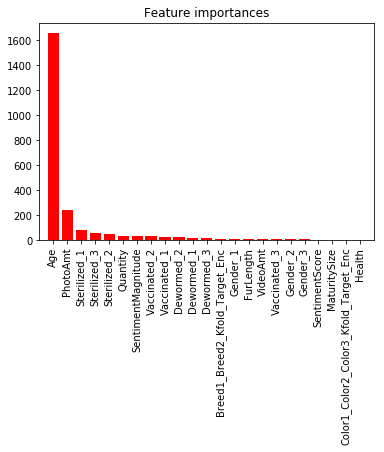

In [37]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores = featureScores.nlargest(X_train.shape[1],'Score')
print(featureScores)  #print 10 best features

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), featureScores['Score'],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), featureScores['Specs'], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

<H2>2.  Feature Importance</H2>

<H3>a. XGBoost</H3>

[2 2 3 ... 2 4 2]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
Quadaratic weighted Kappa: 0.2938558959403659
[0.08027177 0.02940752 0.02844309 0.03441193 0.0458367  0.02003623
 0.04382243 0.03095105 0.03148028 0.06999364 0.04244916 0.03801676
 0.02900102 0.0401706  0.04206835 0.0329835  0.03759392 0.03715412
 0.03462033 0.03947427 0.02546261 0.13177878 0.05457193]
Feature ranking:
1. Sterilized_2 (0.131779)
2. Age (0.080272)
3. Breed1_Breed2_Kfold_Target_Enc (0.069994)
4. Sterilized_3 (0.054572)
5. Quantity (0.045837)
6. PhotoAmt (0.043822)
7. Color1_Color2_Color3_Kfold_Target_Enc (0.042449)
8. Vaccinated_1 (0.042068)
9. Gender_3 (0.040171)
10. Dew

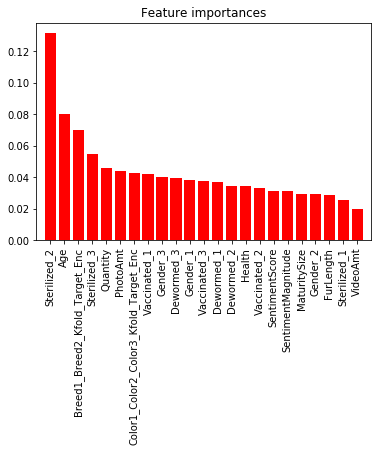

In [38]:
from sklearn.metrics import cohen_kappa_score
from xgboost import XGBClassifier

model = XGBClassifier(objective='multi:softprob', random_state=100)
model.fit(X_train,y_train)

preds_class = model.predict(X_eval)
print(preds_class)
print(model)
print('Quadaratic weighted Kappa:', cohen_kappa_score(y_eval, preds_class, weights='quadratic'))

importances = model.feature_importances_
#std = np.std([m.feature_importances_ for m in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print(importances)

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

<H2>3. Correlation Matrix with Heatmap</H2>

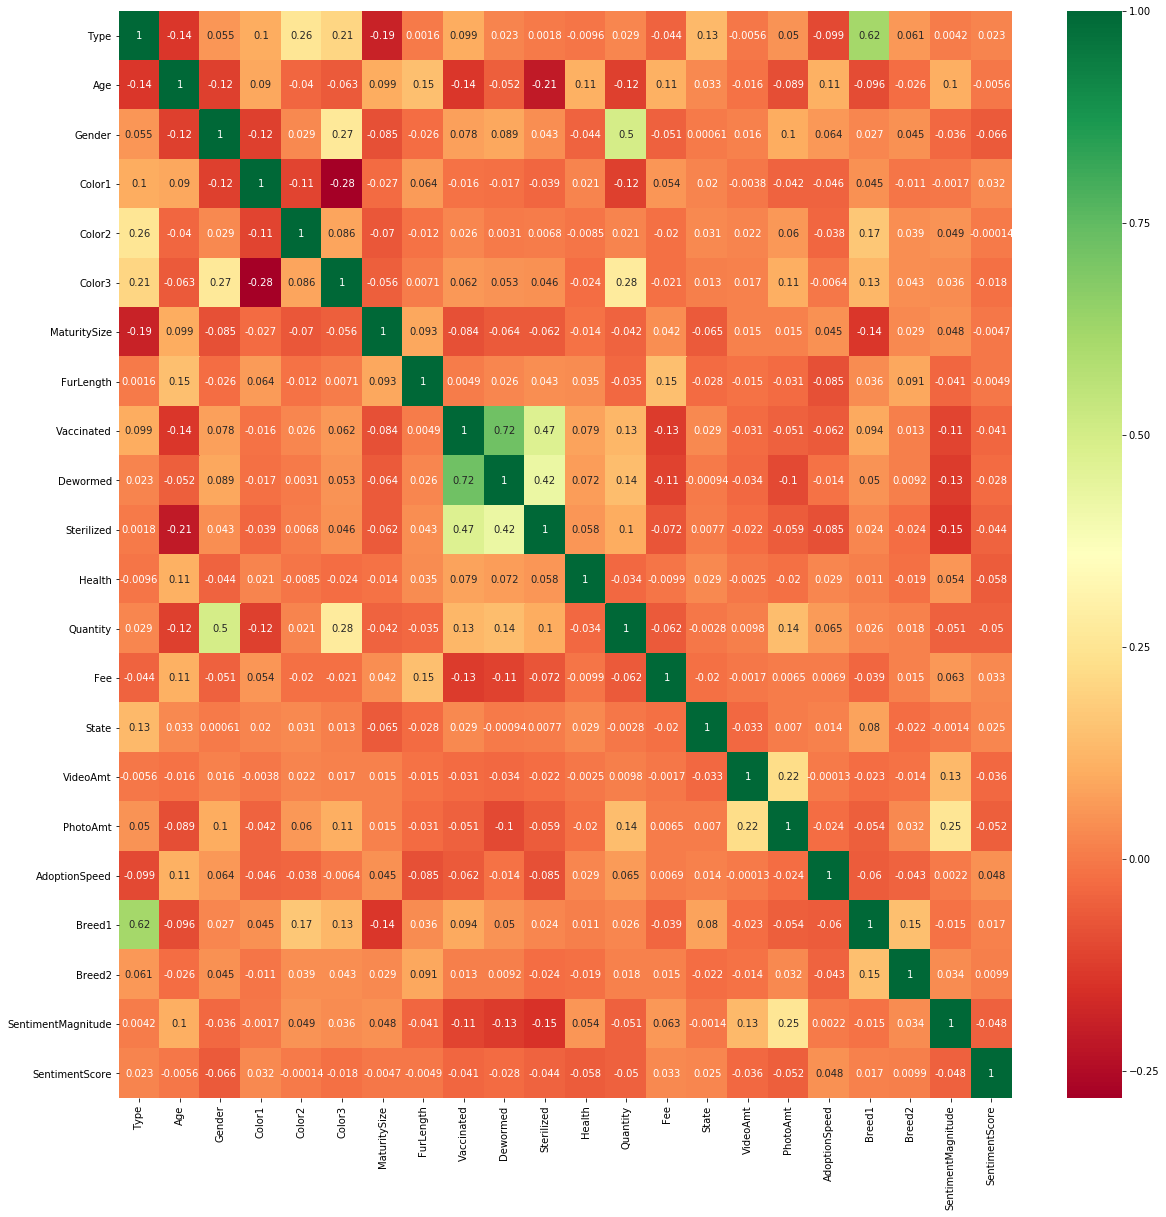

In [39]:
df_heatmap = df_preprocess

#get correlations of each features in dataset
corrmat = df_heatmap.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_heatmap[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<H1>Modeling</H1>

<H2>XGBoost Baseline Model</H2>

XGBoost does not automatically cater for categorical features.  Therefore, we have to manually transform categorical features to fit it into the algorithmn.  In this case, we have used pipeline to transform the data before fitting into the model.  The benefit of defining a pipeline is we can use the same pipeline for training and serving.  When doing serving using the same pipeline, we will make sure the same transformation which is done during training is also carry out during serving before prediction is triggered.

In [40]:
# Let's define the pipeline here

from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler

cat_feature_cols = ['Gender', 'Vaccinated', 'Dewormed', 'Sterilized']
breed_cat_feature_cols = ['Breed1', 'Breed2']
color_cat_feature_cols = ['Color1', 'Color2', 'Color3']

breed_cat_feature_transformer = FunctionTransformer(encode_mul_cat_feature_for_test, validate=False)
color_cat_feature_transformer = FunctionTransformer(encode_mul_cat_feature_for_test, validate=False)
cat_feature_transformer = FunctionTransformer(encode_cat_feature_for_test, validate=False)
scaler = StandardScaler()

preprocess_cols = make_column_transformer(
   (breed_cat_feature_transformer, breed_cat_feature_cols),
   (color_cat_feature_transformer, color_cat_feature_cols),
   (cat_feature_transformer, cat_feature_cols),
   remainder = 'passthrough' 
)

preprocess_all =  Pipeline([('preprocess', preprocess_cols), ('scaler', scaler)])

In [41]:
from sklearn.metrics import cohen_kappa_score
from xgboost import XGBClassifier

X_train = train_set[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]
y_train = train_set['AdoptionSpeed']

X_eval = eval_set[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]
y_eval = eval_set['AdoptionSpeed']

model = XGBClassifier(objective='multi:softprob', random_state=100)

pipeline = Pipeline([('all_preprocess', preprocess_all), ('clf', model)])
pipeline.fit(X_train,y_train)

preds_class = pipeline.predict(X_eval)
print(preds_class)
print(model)
print('Quadaratic weighted Kappa:', cohen_kappa_score(y_eval, preds_class, weights='quadratic'))


[2 2 3 ... 1 4 2]
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob',
       random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)
Quadaratic weighted Kappa: 0.2985677544697667


The baseline score of XGBoost is Cohen Kappa score of 0.29856.  Let's do some hyperparameter tuning to improve the model.

<H1>Hyperparameter Tuning</H1>

In [ ]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'train_time'])
of_connection.close()

In [ ]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from catboost import Pool, cv

# Global variable
global  ITERATION

ITERATION = 0
N_FOLDS = 10
MAX_EVALS = 100

# Define the search space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.5, 1.0), 
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0.0, 1.0),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

# optimization algorithm
tpe_algorithm = tpe.suggest

# Keep track of results
bayes_trials = Trials()

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    xgboost_clf =  xgb.XGBClassifier(n_estimators=200)
    
    pipeline_clf = Pipeline([('all_preprocess', preprocess_all), ('clf', xgboost_clf)])
    
    pipeline_clf.set_params(clf__max_depth=int(params.get('max_depth')),
        clf__learning_rate=float(params.get('learning_rate')),
        clf__min_child_weight=int(params.get('min_child_weight')),
        clf__min_child_samples=int(params.get('min_child_samples')),
        clf__reg_alpha=float(params.get('reg_alpha')),
        clf__reg_lambda=float(params.get('reg_lambda')),
        clf__subsample=float(params.get('subsample')),
        clf__colsample_bytree=float(params.get('colsample_bytree')),
        clf__gamma=float(params.get('gamma')),
        clf__num_class=5,
        )
    
    run_time = timer() - start
    
    cv_scores = cross_val_score(pipeline_clf, X_train, y_train, cv=N_FOLDS, scoring='accuracy', n_jobs=-1)
    
    # Extract the best score
    best_score = cv_scores.mean()
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    #n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            #'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}



In [ ]:
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

In [ ]:
import ast

results = pd.read_csv('gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

From the hyperparameter tuning, the best params obtained are
<br>
<br>
                    {'colsample_bytree': 0.778884081281215,
                     'gamma': 0.007399069550129256,
                     'learning_rate': 0.031642623234827805,
                     'max_depth': 9,
                     'min_child_samples': 225,
                     'min_child_weight': 1,
                     'n_estimators': 95,
                     'reg_alpha': 0.5005020213127344,
                     'reg_lambda': 0.45121616279208887,
                     'subsample': 0.9304947779168935,
                     'num_class': 5}

<H1>Train using the best params</H1>

In [42]:
from sklearn.metrics import cohen_kappa_score
from xgboost import XGBClassifier

X_train = train_set[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]
y_train = train_set['AdoptionSpeed']

X_eval = eval_set[['Age', 'Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Gender', 'MaturitySize', 'FurLength', 
                  'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'VideoAmt', 'PhotoAmt', 'SentimentMagnitude', 'SentimentScore']]
y_eval = eval_set['AdoptionSpeed']

best_bayes_params = {'colsample_bytree': 0.778884081281215,
                     'gamma': 0.007399069550129256,
                     'learning_rate': 0.031642623234827805,
                     'max_depth': 9,
                     'min_child_samples': 225,
                     'min_child_weight': 1,
                     'n_estimators': 95,
                     'reg_alpha': 0.5005020213127344,
                     'reg_lambda': 0.45121616279208887,
                     'subsample': 0.9304947779168935,
                     'num_class': 5}

model = XGBClassifier(objective='multi:softprob', random_state=100, **best_bayes_params)

pipeline = Pipeline([('all_preprocess', preprocess_all), ('clf', model)])
pipeline.fit(X_train,y_train)

print(model)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.778884081281215, gamma=0.007399069550129256,
       learning_rate=0.031642623234827805, max_delta_step=0, max_depth=9,
       min_child_samples=225, min_child_weight=1, missing=None,
       n_estimators=95, n_jobs=1, nthread=None, num_class=5,
       objective='multi:softprob', random_state=100,
       reg_alpha=0.5005020213127344, reg_lambda=0.45121616279208887,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9304947779168935)


In [43]:
# getting test dataset for prediction
df_test = pd.read_csv("../input/test/test.csv")
df_test.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,2,Dopey & Grey,8,266,266,1,2,6,7,1,1,1,1,2,1,2,0,41326,2ece3b2573dcdcebd774e635dca15fd9,0,"Dopey Age: 8mths old Male One half of a pair, ...",e2dfc2935,2.0
1,2,Chi Chi,36,285,264,2,1,4,7,2,3,1,1,1,2,1,0,41326,2ece3b2573dcdcebd774e635dca15fd9,0,"Please note that Chichi has been neutered, the...",f153b465f,1.0
2,2,Sticky,2,265,0,1,6,7,0,2,2,1,1,2,1,1,200,41326,e59c106e9912fa30c898976278c2e834,0,"Sticky, named such because of his tendency to ...",3c90f3f54,4.0
3,1,Dannie & Kass [In Penang],12,307,0,2,2,5,0,2,2,1,1,1,1,2,0,41326,e59c106e9912fa30c898976278c2e834,0,Dannie and Kass are mother and daughter. We en...,e02abc8a3,5.0
4,2,Cuddles,12,265,0,1,2,3,7,2,2,1,1,1,1,1,0,41326,e59c106e9912fa30c898976278c2e834,0,"Extremely cuddly cat, hence the origin of his ...",09f0df7d1,5.0


In [44]:
pipeline = Pipeline([('all_preprocess', preprocess_all), ('clf', model)])
pipeline.predict(df_test)

array([2, 0, 2, ..., 3, 1, 1])